# Decision Trees

In this notebook I will implement decision tree models for both classification and regression.  I will use the breast cancer dataset from Article II to test the classification model, while the regression model will be tested using synthetic data.  Both implemented models will be compared to the decision trees available through scikit-learn.

In [1]:
# imports
from __future__ import annotations
from typing import Tuple
from abc import ABC,abstractmethod
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer,make_regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,mean_squared_error,mean_absolute_error,r2_score

In [2]:
class Node(object):
    """
    Class to define & control tree nodes
    """
    
    def __init__(self) -> None:
        """
        Initializer for a Node class instance
        """
        self.__split    = None
        self.__feature  = None
        self.__left     = None
        self.__right    = None
        self.leaf_value = None

    def set_params(self, split: float, feature: int) -> None:
        """
        Set the split & feature parameters for this node
        
        Input:
            split   -> value to split feature on
            feature -> index of feature to be used in splitting 
        """
        self.__split   = split
        self.__feature = feature
        
    def get_params(self) -> Tuple[float,int]:
        """
        Get the split & feature parameters for this node
        
        Output:
            Tuple containing (split,feature) pair
        """
        return(self.__split, self.__feature)    
        
    def set_children(self, left: Node, right: Node) -> None:
        """
        Set the left/right child nodes for the current node
        
        Inputs:
            left  -> LHS child node
            right -> RHS child node
        """
        self.__left  = left
        self.__right = right
        
    def get_left_node(self) -> Node:
        """
        Get the left child node
        
        Output:
            LHS child node
        """
        return(self.__left)
    
    def get_right_node(self) -> Node:
        """
        Get the RHS child node
        
        Output:
            RHS child node
        """
        return(self.__right)

In [3]:
class DecisionTree(ABC):
    """
    Base class to encompass the CART algorithm
    """
    
    def __init__(self, max_depth: int=None, min_samples_split: int=2) -> None:
        """
        Initializer
        
        Inputs:
            max_depth         -> maximum depth the tree can grow
            min_samples_split -> minimum number of samples required to split a node
        """
        self.tree              = None
        self.max_depth         = max_depth
        self.min_samples_split = min_samples_split
        
    @abstractmethod
    def _impurity(self, D: np.array) -> None:
        """
        Protected function to define the impurity
        """
        pass
        
    @abstractmethod
    def _leaf_value(self, D: np.array) -> None:
        """
        Protected function to compute the value at a leaf node
        """
        pass
        
    def __grow(self, node: Node, D: np.array, level: int) -> None:
        """
        Private recursive function to grow the tree during training
        
        Inputs:
            node  -> input tree node
            D     -> sample of data at node 
            level -> depth level in the tree for node
        """
        # are we in a leaf node?
        depth = (self.max_depth is None) or (self.max_depth >= (level+1))
        msamp = (self.min_samples_split <= D.shape[0])
        n_cls = np.unique(D[:,-1]).shape[0] != 1
        
        # not a leaf node
        if depth and msamp and n_cls:
        
            # initialize the function parameters
            ip_node = None
            feature = None
            split   = None
            left_D  = None
            right_D = None
            # iterate through the possible feature/split combinations
            for f in range(D.shape[1]-1):
                for s in np.unique(D[:,f]):
                    # for the current (f,s) combination, split the dataset
                    D_l = D[D[:,f]<=s]
                    D_r = D[D[:,f]>s]
                    # ensure we have non-empty arrays
                    if D_l.size and D_r.size:
                        # calculate the impurity
                        ip  = (D_l.shape[0]/D.shape[0])*self._impurity(D_l) + (D_r.shape[0]/D.shape[0])*self._impurity(D_r)
                        # now update the impurity and choice of (f,s)
                        if (ip_node is None) or (ip < ip_node):
                            ip_node = ip
                            feature = f
                            split   = s
                            left_D  = D_l
                            right_D = D_r
            # set the current node's parameters
            node.set_params(split,feature)
            # declare child nodes
            left_node  = Node()
            right_node = Node()
            node.set_children(left_node,right_node)
            # investigate child nodes
            self.__grow(node.get_left_node(),left_D,level+1)
            self.__grow(node.get_right_node(),right_D,level+1)
                        
        # is a leaf node
        else:
            
            # set the node value & return
            node.leaf_value = self._leaf_value(D)
            return
     
    def __traverse(self, node: Node, Xrow: np.array) -> int | float:
        """
        Private recursive function to traverse the (trained) tree
        
        Inputs:
            node -> current node in the tree
            Xrow -> data sample being considered
        Output:
            leaf value corresponding to Xrow
        """        
        # check if we're in a leaf node?
        if node.leaf_value is None:
            # get parameters at the node
            (s,f) = node.get_params()
            # decide to go left or right?
            if (Xrow[f] <= s):
                return(self.__traverse(node.get_left_node(),Xrow))
            else:
                return(self.__traverse(node.get_right_node(),Xrow))
        else:
            # return the leaf value
            return(node.leaf_value)
    
    def train(self, Xin: np.array, Yin: np.array) -> None:
        """
        Train the CART model
        
        Inputs:
            Xin -> input set of predictor features
            Yin -> input set of labels
        """        
        # prepare the input data
        D = np.concatenate((Xin,Yin.reshape(-1,1)),axis=1)
        # set the root node of the tree
        self.tree = Node()
        # build the tree
        self.__grow(self.tree,D,1)
        
    def predict(self, Xin: np.array) -> np.array:
        """
        Make predictions from the trained CART model
        
        Input:
            Xin -> input set of predictor features
        Output:
            array of prediction values
        """
        # iterate through the rows of Xin
        p = []
        for r in range(Xin.shape[0]):
            p.append(self.__traverse(self.tree,Xin[r,:]))
        # return predictions
        return(np.array(p).flatten())

In [4]:
class DecisionTreeClassifier(DecisionTree):
    """
    Decision Tree Classifier
    """
    
    def __init__(self, max_depth: int=None, min_samples_split: int=2, loss: str='gini') -> None:
        """
        Initializer
        
        Inputs:
            max_depth         -> maximum depth the tree can grow
            min_samples_split -> minimum number of samples required to split a node
            loss              -> loss function to use during training
        """
        DecisionTree.__init__(self,max_depth,min_samples_split)
        self.loss = loss   
    
    def __gini(self, D: np.array) -> float:
        """
        Private function to define the gini impurity
        
        Input:
            D -> data to compute the gini impurity over
        Output:
            Gini impurity for D
        """        
        # initialize the output
        G = 0
        # iterate through the unique classes
        for c in np.unique(D[:,-1]):
            # compute p for the current c
            p = D[D[:,-1]==c].shape[0]/D.shape[0]
            # compute term for the current c
            G += p*(1-p)
        # return gini impurity
        return(G)
    
    def __entropy(self, D: np.array) -> float:
        """
        Private function to define the shannon entropy
        
        Input:
            D -> data to compute the shannon entropy over
        Output:
            Shannon entropy for D
        """        
        # initialize the output
        H = 0
        # iterate through the unique classes
        for c in np.unique(D[:,-1]):
            # compute p for the current c
            p = D[D[:,-1]==c].shape[0]/D.shape[0]
            # compute term for the current c
            H -= p*np.log2(p)
        # return entropy
        return(H)
    
    def _impurity(self, D: np.array) -> float:
        """
        Protected function to define the impurity
        
        Input:
            D -> data to compute the impurity metric over
        Output:
            Impurity metric for D        
        """        
        # use the selected loss function to calculate the node impurity
        ip = None
        if self.loss == 'gini':
            ip = self.__gini(D)
        elif self.loss == 'entropy':
            ip = self.__entropy(D)
        # return results
        return(ip)
    
    def _leaf_value(self, D: np.array) -> int:
        """
        Protected function to compute the value at a leaf node
        
        Input:
            D -> data to compute the leaf value
        Output:
            Mode of D         
        """        
        return(stats.mode(D[:,-1],keepdims=False)[0])

In [5]:
class DecisionTreeRegressor(DecisionTree):
    """
    Decision Tree Regressor
    """
    
    def __init__(self, max_depth: int=None, min_samples_split: int=2, loss: str='mse') -> None:
        """
        Initializer
        
        Inputs:
            max_depth         -> maximum depth the tree can grow
            min_samples_split -> minimum number of samples required to split a node
            loss              -> loss function to use during training
        """        
        DecisionTree.__init__(self,max_depth,min_samples_split)
        self.loss = loss   
    
    def __mse(self, D: np.array) -> float:
        """
        Private function to define the mean squared error
        
        Input:
            D -> data to compute the MSE over
        Output:
            Mean squared error over D
        """
        # compute the mean target for the node
        y_m = np.mean(D[:,-1])
        # compute the mean squared error wrt the mean
        E = np.sum((D[:,-1] - y_m)**2)/D.shape[0]
        # return mse
        return(E)
    
    def __mae(self, D: np.array) -> float:
        """
        Private function to define the mean absolute error
        
        Input:
            D -> data to compute the MAE over
        Output:
            Mean absolute error over D
        """
        # compute the mean target for the node
        y_m = np.mean(D[:,-1])
        # compute the mean absolute error wrt the mean
        E = np.sum(np.abs(D[:,-1] - y_m))/D.shape[0]
        # return mae
        return(E)
    
    def _impurity(self, D: np.array) -> float:
        """
        Protected function to define the impurity
        
        Input:
            D -> data to compute the impurity metric over
        Output:
            Impurity metric for D        
        """            
        # use the selected loss function to calculate the node impurity
        ip = None
        if self.loss == 'mse':
            ip = self.__mse(D)
        elif self.loss == 'mae':
            ip = self.__mae(D)
        # return results
        return(ip)
    
    def _leaf_value(self, D: np.array) -> float:
        """
        Protected function to compute the value at a leaf node
        
        Input:
            D -> data to compute the leaf value
        Output:
            Mean of D           
        """
        return(np.mean(D[:,-1]))

### Classification Model

Let's test out the classification model, using the breast cancer dataset we already examined in Article II

In [6]:
# load classification dataset
data = load_breast_cancer()
X    = data.data
y    = data.target

In [7]:
# what is the shape of the dataset?
print('shape of X: ',X.shape)
print('shape of y: ',y.shape)

shape of X:  (569, 30)
shape of y:  (569,)


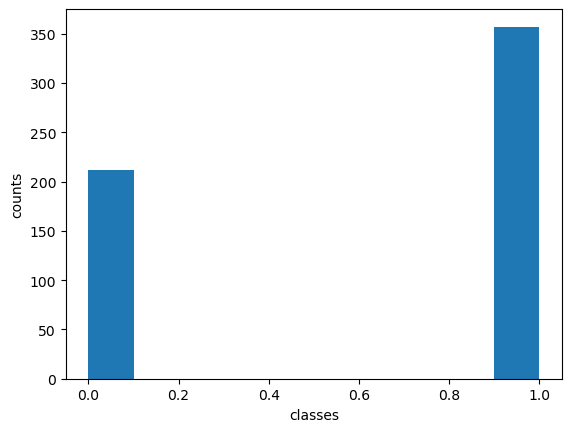

Percentage of y=0:  0.37258347978910367
Percentage of y=1:  0.6274165202108963


In [8]:
# is the dataset balanced?
plt.hist(y)
plt.xlabel('classes')
plt.ylabel('counts')
plt.show()

print('Percentage of y=0: ',y[y==0].shape[0]/y.shape[0])
print('Percentage of y=1: ',y[y==1].shape[0]/y.shape[0])

Clearly this dataset isn't balanced. We will need to account for this prior to training. I'll do this by selecting samples for training based upon their class values, ensuring I get an equal number for each class.  I want to use 60% of the data for training, and test the results on the remaining 40%.

In [9]:
# how many samples do I need per class for training?
nsampclass = int(np.round(y.shape[0]*0.6/2,decimals=0))
nsampclass

171

In [10]:
# partition the training data by label
y0 = y[y==0]
y1 = y[y==1]
X0 = X[y==0]
X1 = X[y==1]
# select the elements to remove at random
idx0 = np.random.choice([i for i in range(y0.shape[0])],size=nsampclass,replace=False)
idx1 = np.random.choice([i for i in range(y1.shape[0])],size=nsampclass,replace=False)
# select samples for training
y_train0 = y0[idx0]
y_train1 = y1[idx1]
X_train0 = X0[idx0,:]
X_train1 = X1[idx1,:]
y_train  = np.concatenate((y_train0,y_train1))
X_train  = np.concatenate((X_train0,X_train1))
# use remainder for testing
y_test0 = np.delete(y0,idx0)
y_test1 = np.delete(y1,idx1)
X_test0 = np.delete(X0,idx0,axis=0)
X_test1 = np.delete(X1,idx1,axis=0)
y_test  = np.concatenate((y_test0,y_test1))
X_test  = np.concatenate((X_test0,X_test1))

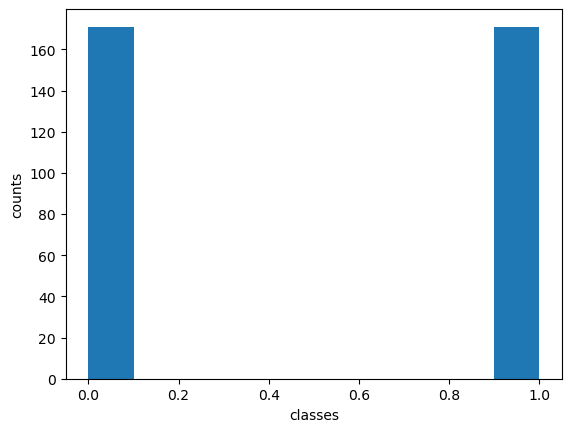

Percentage of y=0:  0.5
Percentage of y=1:  0.5


In [11]:
# is the training dataset balanced now?
plt.hist(y_train)
plt.xlabel('classes')
plt.ylabel('counts')
plt.show()

print('Percentage of y=0: ',y_train[y_train==0].shape[0]/y_train.shape[0])
print('Percentage of y=1: ',y_train[y_train==1].shape[0]/y_train.shape[0])

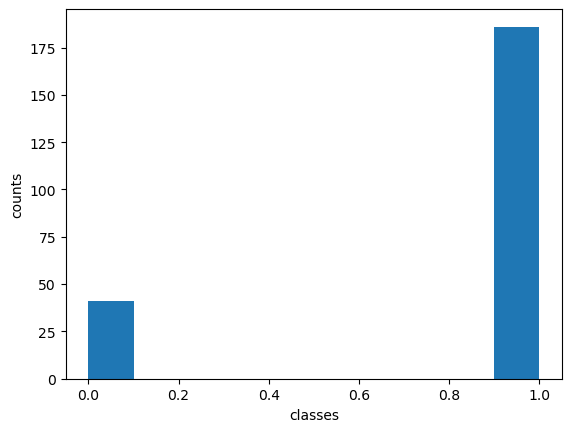

Percentage of y=0:  0.18061674008810572
Percentage of y=1:  0.8193832599118943


In [12]:
# what is the proportion of class 0/1 in the test set?
plt.hist(y_test)
plt.xlabel('classes')
plt.ylabel('counts')
plt.show()

print('Percentage of y=0: ',y_test[y_test==0].shape[0]/y_test.shape[0])
print('Percentage of y=1: ',y_test[y_test==1].shape[0]/y_test.shape[0])

Great, we can see that now there are an equal number of samples for both classes in the training dataset.  Since our feature space is relatively small (30), we will not consider dimension reduction as part of this analysis.

In [13]:
# declare the classifier and train the model
clf = DecisionTreeClassifier(max_depth=5,loss='gini')
clf.train(X_train,y_train)

In [14]:
# generate predictions
yp = clf.predict(X_test)

In [15]:
# evaluate model performance
print("accuracy: %.2f" % accuracy_score(y_test,yp))
print("precision: %.2f" % precision_score(y_test,yp))
print("recall: %.2f" % recall_score(y_test,yp))

accuracy: 0.93
precision: 0.98
recall: 0.93


Below let's compare with the results from the scikit-learn decision tree classifier:

In [16]:
# import the scikit-learn model
from sklearn.tree import DecisionTreeClassifier

In [17]:
# declare the classifier and train the model
clf = DecisionTreeClassifier(max_depth=5,criterion='gini')
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5)

In [18]:
# generate predictions
yp = clf.predict(X_test)

In [19]:
# evaluate model performance
print("accuracy: %.2f" % accuracy_score(y_test,yp))
print("precision: %.2f" % precision_score(y_test,yp))
print("recall: %.2f" % recall_score(y_test,yp))

accuracy: 0.91
precision: 0.97
recall: 0.92


Now let's tabulate the classifier results:

Model | Impurity Metric | Depth | Accuracy | Precision | Recall
-- | -- | -- | -- | -- | --
Custom | Gini | 5 | 0.93 | 0.98 | 0.93
Scikit | Gini | 5 | 0.93 | 0.98 | 0.93
Custom | Entropy | 5 | 0.93 | 0.97 | 0.95
Scikit | Entropy | 5 | 0.92 | 0.98 | 0.92
Custom | Gini | 10 | 0.90 | 0.98 | 0.90
Scikit | Gini | 10 | 0.93 | 0.98 | 0.93
Custom | Entropy | 10 | 0.91 | 0.98 | 0.91
Scikit | Entropy | 10 | 0.91 | 0.96 | 0.93

The results indicate the scikit-learn model and our custom built classifier are roughly compariable for all hyperparameter configurations attempted. Note the model shows signs of overfitting when the maximum tree depth is set to 10. Let's move on to test the performance of our regressor.

### Regression Model

We can check the performance of the regression tree model on a dummy dataset generated using the make_regression function from scikit-learn.  The dataset will consist of 8 features in total, 5 of which will be informative for the single target.  The standard deviation in the noise is set to 1, and a total of 1000 samples is generated.

In [20]:
# create a regression dataset
X,y = make_regression(n_samples=1000, n_features=8, n_informative=5, n_targets=1, noise=1, random_state=42)

In [21]:
# do train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
# declare the regressor and train the model
rgr = DecisionTreeRegressor(max_depth=5,loss='mae')
rgr.train(X_train,y_train)

In [23]:
# make predictions
yp = rgr.predict(X_test)

In [24]:
# evaluate model performance
print("rmse: %.2f" % np.sqrt(mean_squared_error(y_test,yp)))
print("mae: %.2f" % mean_absolute_error(y_test,yp))
print("r2: %.2f" % r2_score(y_test,yp))

rmse: 70.04
mae: 56.44
r2: 0.68


In [25]:
# import the scikit-learn model
from sklearn.tree import DecisionTreeRegressor

In [28]:
# declare the regressor and train the model
rgr = DecisionTreeRegressor(max_depth=5,criterion='absolute_error')
rgr.fit(X_train,y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=5)

In [29]:
# make predictions
yp = rgr.predict(X_test)

In [30]:
# evaluate model performance
print("rmse: %.2f" % np.sqrt(mean_squared_error(y_test,yp)))
print("mae: %.2f" % mean_absolute_error(y_test,yp))
print("r2: %.2f" % r2_score(y_test,yp))

rmse: 63.68
mae: 49.35
r2: 0.74


Now let's tabulate the regressor results:

Model | Impurity Metric | Depth | RMSE | MAE' | R2
-- | -- | -- | -- | -- | --
Custom | MSE | 5 | 69.05 | 55.91 | 0.69
Scikit | MSE | 5 | 66.31 | 53.61 | 0.71
Custom | MAE | 5 | 70.04 | 56.44 | 0.68
Scikit | MAE | 5 | 63.68 | 49.35 | 0.74
Custom | MSE | 10 | 64.07 | 48.85 | 0.73
Scikit | MSE | 10 | 59.72 | 45.56 | 0.77
Custom | MAE | 10 | 55.53 | 41.88 | 0.80
Scikit | MAE | 10 | 56.09 | 42.19 | 0.80

Note that the mean absolute error is calculated differently for the impurity metric (MAE) versus evaluation metric (MAE'): 
* The impurity metric is computed with respect to the mean of the label values for any given node in the tree
* The evaluation metric is computed by taking the difference between predicted and actual label values for the entire test set

For 3/4 of the configurations tested, the scikit-learn regressor outperforms our custom built model. This is notable for the {impurity = MAE, depth = 5} and {impurity = MSE, depth = 10} configurations.  

The custom built model performs better for the {impurity = MAE, depth = 10} configuration, however. This is also the best performing model overall.

To improve performance of the custom built model, feel free to try replacing the mean (y_m) in the private impurity functions with the median. You can also try using deeper trees, since overfitting does not appear to be an issue here.